In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 708.0MB 24kB/s 
     |████████████████████████████████| 5.9MB 26.7MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [ ]:
import pandas as pd
import numpy as np
import time
import spacy
import random
from pathlib import Path
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchtext import data 
import torchtext
from nltk.tokenize.treebank import TreebankWordDetokenizer

In [ ]:
#check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print('Using device:', device)
print()

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

torch.backends.cudnn.deterministic = True

cuda
Using device: cuda

Tesla P100-PCIE-16GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:346: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


<a id='section1'></a>
# **1. Dataset Preparation**


In [ ]:
test_data = pd.read_csv("/content/test-2.csv")
train_data = pd.read_csv("/content/train-2.csv")
valid_data = pd.read_csv("/content/val.csv")

<a id='section2'></a>
# **2. Preprocessing**

In [ ]:
# check the length of the sequence
TEXT = torchtext.data.Field(tokenize='spacy', lower=True, include_lengths= True)

LABEL = torchtext.data.LabelField(dtype=torch.float)

# Map data to fields
fields = [('text', TEXT), ('label', LABEL)]

# create torch dataset
test_data = torchtext.data.TabularDataset(
        path="/content/test-2.csv",
        format="CSV",
        fields=fields,
        skip_header=False)

train_data = torchtext.data.TabularDataset(
        path="/content/train-2.csv",
        format="CSV",
        fields=fields,
        skip_header=False)

valid_data = torchtext.data.TabularDataset(
        path="/content/val.csv",
        format="CSV",
        fields=fields,
        skip_header=False)

print("Number of train data: {}".format(len(train_data)))
print("Number of test data: {}".format(len(test_data)))
print("Number of validation data: {}".format(len(valid_data)))

Number of train data: 11320
Number of test data: 5661
Number of validation data: 5660


In [ ]:
print(vars(train_data.examples[0]))

{'text': ['i', 'received', 'this', 'romper', 'last', 'week', 'and', 'have', 'already', 'worn', 'it', 'twice', '.', 'it', 'is', 'soooo', 'comfortable', 'and', 'the', 'material', 'is', 'really', 'soft', '.', 'the', 'romper', 'is', 'loose', ',', 'yet', 'fitted', 'and', 'very', 'cute', '.', 'i', 'love', 'the', 'open', 'back', 'and', 'the', 'shorts', 'are', 'just', 'the', 'right', 'length', '.', 'i', 'wish', 'there', 'were', 'other', 'patterns', 'or', 'colors', 'available', ',', 'too', '.', 'i', 'would', 'definitely', 'buy', 'again', '!'], 'label': '1'}


In [ ]:
# Build Vocabulary

MAX_VOCAB_SIZE = 25000

# using the Gaussian distribution
TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE,
                 vectors = "glove.6B.100d",
                 unk_init = torch.Tensor.normal_)

# build vocab for training set - convert words into integers
LABEL.build_vocab(train_data)

# top 10
TEXT.vocab.freqs.most_common(10)

.vector_cache/glove.6B.zip: 862MB [06:27, 2.23MB/s]                          
100%|█████████▉| 399642/400000 [00:16<00:00, 25807.95it/s]

[('.', 45023),
 ('the', 37922),
 ('i', 33441),
 ('it', 24641),
 ('and', 24484),
 (',', 23854),
 ('a', 21405),
 ('is', 15703),
 ('this', 12938),
 ('to', 12364)]

In [ ]:
# Iterator

BATCH_SIZE = 128

# sort_within_batch sorts all the tensors within a batch by their lengths
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    device = device,
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch = True)

<a id='section3'></a>
# **3. Model**

In [ ]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
       
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)

        # LSTM layer
        # returns the output and a tuple of the final hidden state and final cell state
        self.encoder = nn.LSTM(embedding_dim, 
                               hidden_dim, 
                               num_layers=n_layers,
                               bidirectional=bidirectional,
                               dropout=dropout)
        
        # Fully-connected layer
        self.predictor = nn.Linear(hidden_dim*2, output_dim)

        # Initialize dropout layer for regularization
        self.dropout = nn.Dropout(dropout)
      
    def forward(self, text, text_lengths):

        # embedded sentence len, batch size, dim
        embedded = self.dropout(self.embedding(text))    

        # pack the embeddings
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)

        # output of encoder
        packed_output, (hidden, cell) = self.encoder(packed_embedded)

        # transform packed sequence to a tensor
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))

        return self.predictor(hidden)

### **Create Model**

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
# 2 layers of biLSTM
N_LAYERS = 2
BIDIRECTIONAL = True
# Dropout
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = LSTM(INPUT_DIM,
            EMBEDDING_DIM,
            HIDDEN_DIM,
            OUTPUT_DIM,
            N_LAYERS,
            BIDIRECTIONAL,
            DROPOUT,
            PAD_IDX)

In [ ]:
print(vars(train_iterator.dataset[0]))

{'text': ['i', 'received', 'this', 'romper', 'last', 'week', 'and', 'have', 'already', 'worn', 'it', 'twice', '.', 'it', 'is', 'soooo', 'comfortable', 'and', 'the', 'material', 'is', 'really', 'soft', '.', 'the', 'romper', 'is', 'loose', ',', 'yet', 'fitted', 'and', 'very', 'cute', '.', 'i', 'love', 'the', 'open', 'back', 'and', 'the', 'shorts', 'are', 'just', 'the', 'right', 'length', '.', 'i', 'wish', 'there', 'were', 'other', 'patterns', 'or', 'colors', 'available', ',', 'too', '.', 'i', 'would', 'definitely', 'buy', 'again', '!'], 'label': '1'}


In [ ]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([11683, 100])


In [ ]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 2.5424, -0.8949, -0.0818,  ...,  2.3655,  1.1772, -0.7489],
        [-0.2842,  0.0508, -0.2704,  ..., -0.5652, -0.5140, -0.9930],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288],
        ...,
        [ 1.3107,  0.2597,  1.8478,  ...,  0.5442,  0.3644,  1.1504],
        [ 1.5809,  0.3643,  1.0965,  ..., -0.1399, -1.2505, -0.2776],
        [-1.4043, -0.6971, -0.7780,  ...,  0.7958,  1.3835,  1.5567]])

In [ ]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288],
        ...,
        [ 1.3107,  0.2597,  1.8478,  ...,  0.5442,  0.3644,  1.1504],
        [ 1.5809,  0.3643,  1.0965,  ..., -0.1399, -1.2505, -0.2776],
        [-1.4043, -0.6971, -0.7780,  ...,  0.7958,  1.3835,  1.5567]])


<a id='section4'></a>
# **4. Training**

In [ ]:
# Adam optimizer 
optimizer = optim.Adam(model.parameters(), lr=2e-2)

criterion = nn.BCEWithLogitsLoss()

# Use GPU
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def batch_accuracy(predictions, label):

    preds = torch.round(torch.sigmoid(predictions))
    correct = (preds == label).float()
    accuracy = correct.sum() / len(correct)

    return accuracy

def timer(start_time, end_time):

    time = end_time - start_time
    mins = int(time / 60)
    secs = int(time - (mins * 60))

    return mins, secs

In [ ]:
def train(model, iterator, optimizer, criterion):
   
    training_loss = 0.0
    training_acc = 0.0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()      
        text, text_lengths = batch.text
        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions, batch.label)
        accuracy = batch_accuracy(predictions, batch.label)
        loss.backward()
        optimizer.step()
        
        training_loss += loss.item()
        training_acc += accuracy.item()

    return training_loss / len(iterator), training_acc / len(iterator)

def evaluate(model, iterator, criterion):

    eval_loss = 0.0
    eval_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            accuracy = batch_accuracy(predictions, batch.label)

            eval_loss += loss.item()
            eval_acc += accuracy.item()
        
    return eval_loss / len(iterator), eval_acc / len(iterator)

### **Train the model**

In [ ]:
NUM_EPOCHS = 25

best_valid_loss = float('inf')

for epoch in range(NUM_EPOCHS):

    start_time = time.time()
    
    # Evaluate training loss and accuracy
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    # Evaluate validation loss and accuracy
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    mins, secs = timer(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model-small.pt')

    print("Epoch {}:".format(epoch+1))
    print("\t Total Time: {}m {}s".format(mins, secs))
    print("\t Train Loss {} | Train Accuracy: {}%".format(round(train_loss, 2), round(train_acc*100, 2)))
    print("\t Validation Loss {} | Validation Accuracy: {}%".format(round(valid_loss, 2), round(valid_acc*100, 2)))

Epoch 1:
	 Total Time: 0m 4s
	 Train Loss 0.57 | Train Accuracy: 76.69%
	 Validation Loss 0.53 | Validation Accuracy: 76.81%


100%|█████████▉| 399642/400000 [00:30<00:00, 25807.95it/s]

Epoch 2:
	 Total Time: 0m 4s
	 Train Loss 0.53 | Train Accuracy: 76.91%
	 Validation Loss 0.53 | Validation Accuracy: 76.81%
Epoch 3:
	 Total Time: 0m 4s
	 Train Loss 0.53 | Train Accuracy: 76.24%
	 Validation Loss 0.55 | Validation Accuracy: 69.88%
Epoch 4:
	 Total Time: 0m 4s
	 Train Loss 0.46 | Train Accuracy: 78.44%
	 Validation Loss 0.42 | Validation Accuracy: 81.88%
Epoch 5:
	 Total Time: 0m 4s
	 Train Loss 0.36 | Train Accuracy: 84.44%
	 Validation Loss 0.36 | Validation Accuracy: 82.79%
Epoch 6:
	 Total Time: 0m 4s
	 Train Loss 0.35 | Train Accuracy: 84.21%
	 Validation Loss 0.36 | Validation Accuracy: 83.6%
Epoch 7:
	 Total Time: 0m 4s
	 Train Loss 0.34 | Train Accuracy: 85.18%
	 Validation Loss 0.39 | Validation Accuracy: 81.93%
Epoch 8:
	 Total Time: 0m 4s
	 Train Loss 0.38 | Train Accuracy: 83.16%
	 Validation Loss 0.4 | Validation Accuracy: 81.56%
Epoch 9:
	 Total Time: 0m 4s
	 Train Loss 0.39 | Train Accuracy: 82.25%
	 Validation Loss 0.42 | Validation Accuracy: 78.58%
Ep

<a id='section5'></a>
# **5. Prediction**

In [ ]:
# Load the model with the best validation loss
model.load_state_dict(torch.load('model-small.pt'))

# Evaluate test loss and accuracy
test_loss, test_acc = evaluate(model, test_iterator, criterion)

#test dataset
print("Test Loss: {} | Test Acc: {}%".format(round(test_loss, 2), round(test_acc*100, 2)))

Test Loss: 0.37 | Test Acc: 82.94%


In [ ]:
nlp = spacy.load('en')
pred = []

def predict(model, text, tokenized=True):

    model.eval()

    if tokenized == False:
        tokens = [token.text for token in nlp.tokenizer(text)]
    else:
        tokens = text
        

    indexed_tokens = [TEXT.vocab.stoi[t] for t in tokens]
    length = [len(indexed_tokens)]
    tensor = torch.LongTensor(indexed_tokens).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = 1-torch.round(torch.sigmoid(model(tensor,length_tensor)))
    pred.append(prediction.item())

    return prediction.item()

In [ ]:
for i in range(len(test_data)):
    predict(model, test_data[i].text)

label = []
for i in range(len(test_data)):
  label.append(int(test_data[i].label))

In [ ]:
print(pred)

[1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0,

In [ ]:
print(label)

[1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 

In [ ]:
print(len(pred))
print(len(label))

5661
5661


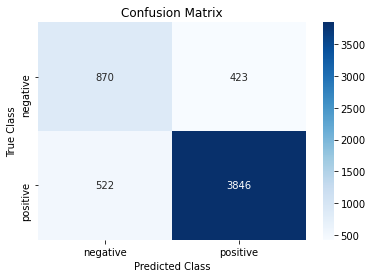

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cnf_mat = confusion_matrix(label,pred)

abbreviations=['negative','positive']
fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_mat, ax=ax, cmap=plt.cm.Blues, annot=True, fmt='g')
ax.set_xticklabels(abbreviations)
ax.set_yticklabels(abbreviations)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

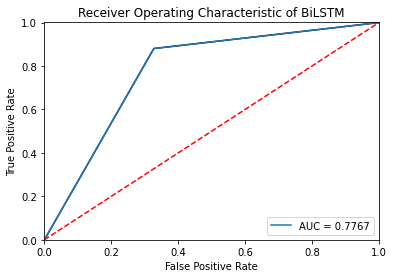

In [ ]:
from sklearn.metrics import auc, roc_curve

fpr, tpr, thresholds = roc_curve(label, pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr,tpr,'k')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of BiLSTM')
plt.show()

In [ ]:
# Single example prediction from the test set
print("Review: {}".format(TreebankWordDetokenizer().detokenize(test_data[10].text)))

print("Prediction: {}".format(round(predict(model, test_data[10].text), 2)))

print("True Label: {}".format(test_data[10].label))

Tweet: first, let me say that the photo does not do this exquisite print justice! the fabric is worth framing! on a white ground, the tones of rose, pink, purple and touches of blue make it even more fabulous! the fit is a tad large, as i am 5' 3 " and usually an size 6, but must size up to 8 or m because of my chest . even zipped, it is a tad big, but nothing that i cannot deal with . i don't really see the swing in the dress, as it does not flare out in any way, but is certainly is loose and flowing, bu
Prediction: 1.0
True Label: 1


In [ ]:
# Example prediction from the test set

d = []


for idx in range(10):

    review = TreebankWordDetokenizer().detokenize(test_data[idx].text)
                                                 
    # Append review, prediction, and true label
    d.append({'Review': review, 'Prediction': predict(model, test_data[idx].text), 'True Label': test_data[idx].label})

pd.DataFrame(d)

,Review,Prediction,True Label
0,the comfort of this fabric is terrific . the s...,1.0,1
1,i ordered this dress in a xs petite . i am 5'0...,0.0,0
2,i have a pair of mih jeans that are the only j...,1.0,0
3,it's easy to miss the fine details that make t...,1.0,1
4,"the fabric is really itchy, i felt like i was ...",0.0,0
5,i bought these about a month ago in the sky bl...,1.0,1
6,this top is my fun splurge for the summer . it...,1.0,1
7,where i live it's warm enough to wear this dre...,1.0,1
8,this top is beautiful to look at but did not f...,0.0,0
9,"lightweight and casual, i picked this jacket u...",1.0,1


In [ ]:
# Load the model with the best validation loss
model.load_state_dict(torch.load('model-small.pt'))

# Evaluate test loss and accuracy
test_loss, test_acc = evaluate(model, test_iterator, criterion)

print("Test Loss: {} | Test Acc: {}%".format(round(test_loss, 2), round(test_acc*100, 2)))

Test Loss: 0.37 | Test Acc: 82.94%


In [ ]:
nlp = spacy.load('en')
pred_pos = []
pred_neg = []

def predict(model, text, tokenized=True):

    model.eval()

    if tokenized == False:
        tokens = [token.text for token in nlp.tokenizer(text)]
    else:
        tokens = text
        
    indexed_tokens = [TEXT.vocab.stoi[t] for t in tokens]
    length = [len(indexed_tokens)]
    tensor = torch.LongTensor(indexed_tokens).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = 1-torch.sigmoid(model(tensor,length_tensor))
    prediction_n = torch.sigmoid(model(tensor,length_tensor))
    pred_pos.append(prediction.item())
    pred_neg.append(prediction_n.item())

    return prediction.item(),prediction_n.item()

In [ ]:
for i in range(len(test_data)):
    predict(model, test_data[i].text)

label = []
for i in range(len(test_data)):
  label.append(int(test_data[i].label))

In [ ]:
print(pred_pos)

[0.8082607984542847, 0.15636581182479858, 0.952862560749054, 0.9940740466117859, 0.10359710454940796, 0.994864821434021, 0.8381643891334534, 0.690538763999939, 0.13276976346969604, 0.9682778716087341, 0.950516402721405, 0.15025049448013306, 0.1445651650428772, 0.1445407271385193, 0.9785208702087402, 0.3722935914993286, 0.994577944278717, 0.9490139484405518, 0.9953137040138245, 0.9867445826530457, 0.18542146682739258, 0.9739981293678284, 0.9764546751976013, 0.23983138799667358, 0.5637808442115784, 0.9896408319473267, 0.977260410785675, 0.13955724239349365, 0.6006977558135986, 0.1559939980506897, 0.9739546775817871, 0.9913079142570496, 0.9865227341651917, 0.3393681049346924, 0.9532274007797241, 0.8190056085586548, 0.3393821716308594, 0.10157710313796997, 0.9809850454330444, 0.29409652948379517, 0.23709017038345337, 0.9890426993370056, 0.09507632255554199, 0.9972526431083679, 0.9942908883094788, 0.9978139400482178, 0.933832049369812, 0.9816266298294067, 0.998092770576477, 0.91385424137115

In [ ]:
print(pred_neg)

[0.19173923134803772, 0.8436341881752014, 0.047137413173913956, 0.005925951525568962, 0.896402895450592, 0.005135156214237213, 0.16183559596538544, 0.30946123600006104, 0.867230236530304, 0.03172215446829796, 0.04948361963033676, 0.8497495055198669, 0.8554348349571228, 0.8554592728614807, 0.021479103714227676, 0.6277064085006714, 0.005422045011073351, 0.05098603293299675, 0.0046862950548529625, 0.013255421072244644, 0.8145785331726074, 0.02600186876952648, 0.023545313626527786, 0.7601686120033264, 0.43621915578842163, 0.010359187610447407, 0.022739561274647713, 0.8604427576065063, 0.399302214384079, 0.8440060019493103, 0.02604534476995468, 0.008692089468240738, 0.013477287255227566, 0.6606318950653076, 0.04677262157201767, 0.1809944063425064, 0.6606178283691406, 0.89842289686203, 0.019014956429600716, 0.7059034705162048, 0.7629098296165466, 0.01095732394605875, 0.904923677444458, 0.0027473503723740578, 0.005709083750844002, 0.0021860827691853046, 0.0661679357290268, 0.01837334409356117

In [ ]:
df = {'pred_0': pred_neg, 'pred_1': pred_pos}
df = pd.DataFrame(df)
df.to_csv('biLSTM.csv')